# Multiclass Softmax Classification - Pytorch (From Scratch)

In [1]:
import torch
from torch import nn
from torchvision import datasets
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu' # will select 'cuda' is gpu is available otherwise 'cpu'
print('Chosen device:', device)

Chosen device: cuda


## Getting our dataset

In [2]:
# transform = lambda image: torch.FloatTensor(image.getdata())/255.0
# or 
def transform(image):
    return torch.FloatTensor(image.getdata())/255.0

train_mnist = datasets.FashionMNIST(root = '~/data', train = True, transform = transform, download = True)
test_mnist = datasets.FashionMNIST(root = '~/data', train = False, transform = transform, download = True)

In [3]:
image, label = train_mnist[0]
print(image.shape, label)

torch.Size([784]) 9


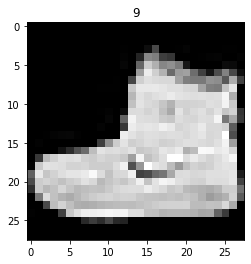

In [4]:
plt.imshow(image.reshape(28, 28), cmap = 'gray')
plt.title(label)
plt.show()

## Creating data loader for training and testing

In [5]:
batch_size = 64
train_data = torch.utils.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = torch.utils.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

print('No of batches for batch size {} is {}'.format(batch_size, len(train_data)))

No of batches for batch size 64 is 938


## Softmax function

$\text{softmax}\left(x\right) = \Large\frac{x_{i}^{e}}{\sum{x_{i}^{e}}}$

In [6]:
def softmax(linear):
    exp = torch.exp(linear - torch.max(linear, axis = 1)[0].reshape(-1, 1))
    # subtracting max for numerical statbility... (it does not affect the outputs)
    norms = torch.sum(exp, axis = 1).reshape(-1, 1)
    return exp / norms

## Building Softmax Classification Model

In pytorch, parameters can be declared using `torch.nn.Parameter`.

In [7]:
weights = nn.Parameter(torch.randn(784, 10, device = device))
bias = nn.Parameter(torch.randn(10, device = device))
params = [weights, bias]

print(weights)
print(bias)

def softmaxclassification(inputs):
    return softmax(torch.mm(inputs, weights) + bias) # mm stands for matrix multiplication

Parameter containing:
tensor([[-1.1620, -0.4008,  0.2235,  ..., -0.2882, -1.4073,  0.8142],
        [ 0.3057, -0.0340, -0.4744,  ...,  0.1168, -0.8009, -0.0691],
        [ 0.0181, -0.1860,  0.1091,  ...,  0.0448,  1.4778,  0.0845],
        ...,
        [ 1.2704, -0.5624,  0.9293,  ...,  1.2590,  0.6020,  2.1873],
        [-1.3132,  2.0698,  1.3379,  ..., -1.4376, -0.7294,  0.5738],
        [-1.2770,  1.1492,  0.5689,  ..., -2.9579,  0.1672, -0.8377]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.1625,  0.8590,  0.1021, -2.2032,  1.3266, -0.7909,  0.2376, -0.2251,
         1.6639,  0.4337], device='cuda:0', requires_grad=True)


## Defining our objective function

### Categorical cross entropy $\left(x\right) = \sum{y_{i} * \log{\hat{y}_{i}}}$

In [8]:
def categoricalcrossentropy(predictions, labels):
    return -torch.sum(labels * torch.log(predictions))

## Defining our parameters optimizer(Gradient Decent)

In [9]:
def sgd(params, lr):
    with torch.no_grad():
        # doing all the parameter updated inside torch.no_grad, because we don't want to record any computation of sgd for backward pass....
        for param in params:
            param -= lr * param.grad
            param.grad.zero_() # zeroing the gradient of after each update so that it would't affect the gradients of for the next update

## Defining our accuracy function

In [10]:
def accuracy(predictions, labels):
    return (predictions.argmax(1) == labels.argmax(1)).float().mean()

## Understanding one hot representation

- If the label is 0 then it's one hot vector is [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

- If the label is 1 then it's one hot vector is [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

- If the label is 2 then it's one hot vector is [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [11]:
import torch.nn.functional as F

def onehot(label):
    return F.one_hot(label, 10).float()

In [12]:
epochs = 20
num_batches = len(train_data)
learning_rate = .001 # you can change it to 0.01 for faster training
losses = []
accs = []

for epoch in range(epochs):
    cumulative_loss = 0
    cumulative_acc = 0
    for features, labels in train_data:
        features = features.to(device) # .to(device) put features stored in cpu to device(which we have initialized above)
        labels = onehot(labels.to(device)) # .to(device) put labels stored in cpu to device(which we have initialized above)
        
        outputs = softmaxclassification(features)
        loss = categoricalcrossentropy(outputs, labels)
        loss.backward()

        sgd(params, learning_rate)
        
        with torch.no_grad():
            cumulative_loss += loss        
            cumulative_acc += accuracy(outputs, labels)

    print(f'Epoch: {epoch} Loss: {cumulative_loss/num_batches} Accuracy: {cumulative_acc/num_batches}')
    losses.append(cumulative_loss/num_batches)
    accs.append(cumulative_acc/num_batches)

Epoch: 0 Loss: 161.68690490722656 Accuracy: 0.582939088344574
Epoch: 1 Loss: 87.1893539428711 Accuracy: 0.7091384530067444
Epoch: 2 Loss: 73.98818969726562 Accuracy: 0.7405384182929993
Epoch: 3 Loss: 66.62698364257812 Accuracy: 0.7581290006637573
Epoch: 4 Loss: 61.616127014160156 Accuracy: 0.7681736350059509
Epoch: 5 Loss: 57.935890197753906 Accuracy: 0.7771188616752625
Epoch: 6 Loss: 55.00849533081055 Accuracy: 0.7838652729988098
Epoch: 7 Loss: 52.60319900512695 Accuracy: 0.7891291379928589
Epoch: 8 Loss: 50.6026725769043 Accuracy: 0.7945262789726257
Epoch: 9 Loss: 48.81060791015625 Accuracy: 0.7976246476173401
Epoch: 10 Loss: 47.330238342285156 Accuracy: 0.801039457321167
Epoch: 11 Loss: 46.025367736816406 Accuracy: 0.8050540089607239
Epoch: 12 Loss: 44.84469985961914 Accuracy: 0.8069030046463013
Epoch: 13 Loss: 43.834373474121094 Accuracy: 0.8089352250099182
Epoch: 14 Loss: 42.887935638427734 Accuracy: 0.8115005493164062
Epoch: 15 Loss: 41.95487976074219 Accuracy: 0.8132496476173401

## Lets see test accuracy

In [14]:
acc = 0.0
test_batches = len(test_data)
for features, labels in test_data:
    features = features.to(device) # .to(device) put features stored in cpu to device(which we have initialized above)
    labels = onehot(labels.to(device)) # .to(device) put labels stored in cpu to device(which we have initialized above)
    outputs = softmaxclassification(features)
    acc += accuracy(outputs, labels)
    
print(f'Test Accuracy: {acc/test_batches}')

Test Accuracy: 0.8110072016716003


In [31]:
def plot(losses = losses, accs = accs, model = softmaxclassification):
    samples = 16
    plt.plot(losses, 'r')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(accs, 'g')
    plt.title('Accuracy during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure(figsize = (15, 15))

    for i, example in enumerate(test_mnist, 1):
        features = example[0].to(device).reshape(1, -1)
        labels = example[1]
        outputs = model(features).argmax(1)
        plt.subplot(4, 4, i)
        plt.imshow(features[0].cpu().reshape(28, 28), cmap = 'gray')
        plt.axis('off')
        plt.title(f'Predicted: {outputs.item()}, Target: {labels}')
        if i == samples:
            break
    plt.show()

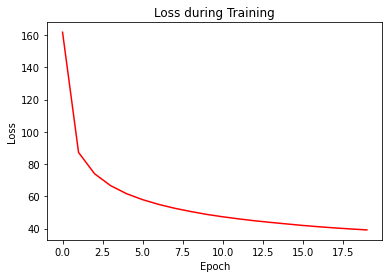

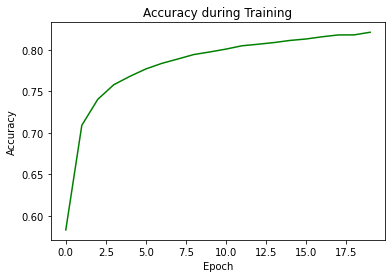

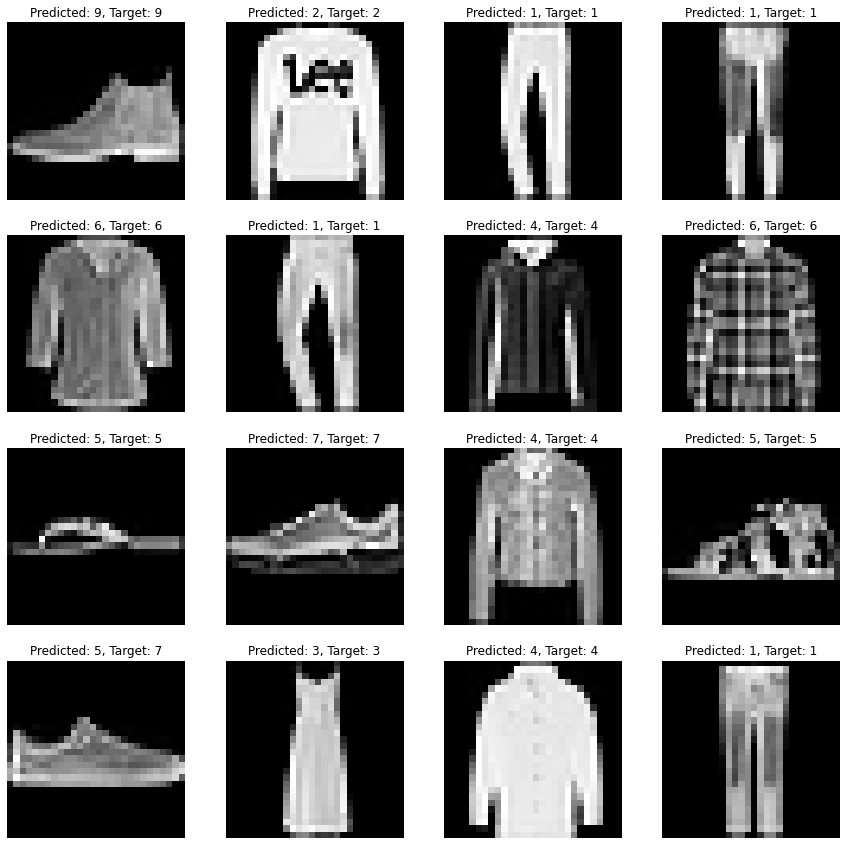

In [32]:
plot()